# Кластеризация вакансий
### Работу выполнили студентки группы ПМ-1401
### Солуянова Н. П., Кучинская Е. А., Иноземцева Н. О.

#### Шаг 0. Обработка данных
Требования к тексту:
1. Вставить текст файла vak_msk_bank_econom.txt в Excel с разделителем двоеточие, чтобы слово «Требуется:» оказалось в первом столбце.
2. Удалить первый столбец.
3. Удалить пустые строки.
4. Некоторые части вакансии могут находиться в разных ячейках, нужно вставить как текст в Word и заменить все знаки табуляции на пробелы, а затем обратно вставить в Excel, чтобы каждая вакансия была в новой строке.
5. Добавить разделитель (например, кавычки) в начале и конце каждой строки (вакансии).
6. Сохранить файл 3vakansii_1.csv
Обработка структурированных по категориям навыков:
1. Соединить два файла финансовое_планирование_все_регионы.txt и экономист_все_регионы.txt с навыками соискателей на экономические вакансии в Excel и убрать повторы, отсортировав по алфавиту.
2. Отсортировать по категориям.
3. Навыки каждой категории сохранить в отдельном файле (vladPO.csv - Владение ПО, comm.csv - Коммуникативные навыки, lich.csv - Личные навыки, econ.csv - Экономические навыки, upr.csv - Управленческие навыки), заменив знаки табуляции на пробелы, чтобы все навыки были в одной ячейке.

#### Шаг 1. Подключаем библиотеки для дальнейшей работы

In [4]:
!pip install -U pymorphy2
!pip install -U pymorphy2-dicts-ru
import pandas as pd
import numpy as np
import pymorphy2
from sklearn.feature_extraction.text import HashingVectorizer

  Running setup.py bdist_wheel for docopt: started
  Running setup.py bdist_wheel for docopt: finished with status 'done'
  Stored in directory: C:\Users\mag\AppData\Local\pip\Cache\wheels\b2\16\5f\c33a2bb5f2dce71205f8e65cbfd05647d79d441282be31fd82
Successfully built docopt


You are using pip version 9.0.1, however version 9.0.3 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


Requirement already up-to-date: pymorphy2-dicts-ru in c:\users\mag\appdata\local\continuum\anaconda3\lib\site-packages


You are using pip version 9.0.1, however version 9.0.3 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


#### Шаг 2. Загружаем файлы с навыками и категориями, к которым они относятся. Объединяем в один файл. Подгружаем файл с вакансиями. 

In [5]:
# filename21-25 файлы с категориями 
filename21 = "vladPO.csv"  # все навыки категории "Владение ПО"
with open(filename21, encoding="cp1251") as file:
    df21 = file.read()
# print(df21)
filename22 = "comm.csv"  # все навыки категории "Коммуникативные навыки"
with open(filename22, encoding="cp1251") as file:
    df22 = file.read()
# print(df22)
filename23 = "lich.csv"  # все навыки категории "Личные навыки"
with open(filename23, encoding="cp1251") as file:
    df23 = file.read()
# print(df23)
filename24 = "econ.csv"  # все навыки категории "Экономические навыки"
with open(filename24, encoding="cp1251") as file:
    df24 = file.read()
# print(df24)
filename25 = "upr.csv"  # все навыки категории "Управленческие навыки"
with open(filename25, encoding="cp1251") as file:
    df25 = file.read()
# print(df25)
df5 = [df21, df22, df23, df24, df25]  # создаём список из всех навыков для каждой категории

# обработанный файл с вакансиями для запроса
filename = "3vakansii_1.csv"
with open(filename, encoding="cp1251") as file:
    df3 = file.read()
# print(df3) 

#### Шаг 3. Напишем функции, очищающие  файл с категориями и файл с вакансиями от знаков препинания

In [6]:
# функция (для вакансий) очищает текст от знаков препинания
def clean(text):
    if not isinstance(text, str):
        raise TypeError('text должен быть str')
    return text.translate(str.maketrans({x: None for x in [',', '.', ':', ';', '!', '?', '«', '»', '–', '[', ']', '(', ')',
                                                           '…', '\n', '/', '\\', '<', '>', 'p', 'u', 'l']}))
clean(df3)
# удаляем строки со знаками препинания и табуляцией, превращая каждую вакансию в элемент списка
df3_split = df3.split('"')  
df3_2 = []
for i in range(len(df3_split)):
    if (df3_split[i] != '') and (df3_split[i] != '\n') and (df3_split[i] != ' '):
        df3_2.append(df3_split[i])
# print(df3_2)   

# функция (для категорий) очищает текст от знаков препинания 
def clean1(text):
    if not isinstance(text, str):
        raise TypeError('text должен быть str')
    return text.translate(str.maketrans({x: None for x in [',', '.', ':', ';', '!', '?', '«', '»', '–', '[', ']', '(', ')',
                                                           '…', '\n', '/', '\\', '<', '>', '"']}))
# чистим тестовые данные от лишних символов
df6 = []
for i in df5:
    df6.append(clean1(i))
# df6

#### Шаг 4. Напишем функцию-токенизатор

In [10]:
# функция, которая будет отвечать за нормализацию и очистку строки
# Функция делает следующее:

#     Сначала она преобразовывает строку в список, затем для всех слов производит разбор
#     Если слово является числительным, предикативом, предлогом, союзом, частицей или междометием, не включаем его в конечный набор
#     Если слово не попало в предыдущий список, берем его нормальную форму и добавляем в финальный набор

def f_tokenizer(s):
    morph = pymorphy2.MorphAnalyzer()
    if type(s) == str:
        t = s.split(' ')
    else:
        t = s
    f = []
    for j in t:
        # clean(j)
        m = morph.parse(j)
        if len(m) != 0:
            wrd = m[0]
            if wrd.tag.POS not in ('NUMR', 'PREP', 'CONJ', 'PRCL', 'INTJ'):
                f.append(wrd.normal_form)
    return f

# цикл, превращающий файл с вакансиями в списки с нормальной формой
df41 = []
for i in df3_2:
    df41.append(f_tokenizer(i))
print(df41)

# цикл, превращающий файл с навыками в списки с нормальной формой
df42 = []
for i in df6:
    df42.append(f_tokenizer(i))
print(df42)

[['', 'высокий', 'образование', '(экономика)', 'опыт', 'работа', 'менее', '5', 'год', 'навык', 'работа', '1c', 'erp', '/', 'упп', 'уверенный', 'пользователь', 'пк', '', ''], ['отличный', 'знание', 'excel.', 'умение', 'анализировать', 'систематизировать', 'статистический', 'данные.', 'знание', 'финансовый', 'показатель', 'деятельность', 'компании.', 'знание', '1с', '8.2,', '8.3.', ''], ['', 'владение', 'английский', 'язык', 'разговорный', 'уровне;', 'релевантный', 'опыт', 'работы;', 'владение', 'пакет', 'ms', 'office.', '', ''], ['', 'опыт', 'работа', 'менее', '3-х', 'лет,', 'практический', 'знание', 'основа', 'бухгалтерский', 'учета;', 'необходимый', 'иметь', 'понятие', '275-фз,', 'методика', 'распределение', 'затрат,', 'особенность', 'процесс', 'ценообразование', 'оформление', 'документ', 'выполнение', 'гоз.', 'знание', '1с', '8.3', 'внимательность', 'работа', 'документами,', 'умение', 'работать', 'больший', 'объём', 'информации;', 'целеустремленность,', 'ответственность.', '', ''], [

[['1с', 'adobe', 'photoshop', 'autocad', 'crm', 'erp', 'ms', 'access', 'ms', 'excel', 'ms', 'office', 'ms', 'outlook', 'ms', 'powerpoint', 'ms', 'project', 'ms', 'visio', 'oracle', 'r-keeper', 'sap', 'sas', 'spss', 'trello', 'vba', 'администрирование', 'сайт', 'анализ', 'дать', 'банк-клиент', 'ведение', 'клиентский', 'база', 'гектор', 'сметчик-строитель', 'инженерный', 'система', 'интернетом-маркетинг', 'информационный', 'технология', 'консультант', 'пользователь', 'пк', 'работа', 'оргтехника', 'сэд', 'дело', 'электронный', 'документооборот', 'lotus', 'notes', 'ms', 'axapta', 'ms', 'sql', 'solid', 'works', 'гарант', 'макрос', 'мой', 'склад', 'наполнение', 'контент', 'работа', 'база', 'дать', 'социальный', 'сеть', 'smetaru', 'галактика', 'гранд', 'смета'], ['pr', 'английский', 'язык', 'ведение', 'переговоры', 'вежливость', 'внутренний', 'коммуникация', 'групповой', 'обучение', 'деловой', 'переписка', 'дистанционный', 'обучение', 'доброжелательность', 'исполнение', 'личный', 'поручение',

### Шаг 5. Функция coding превращает список списков вакансий или навыков в пару [номер вакансии/категории, навык]. Получаем пары вида: [номер вакансии, категория навыка]

In [11]:
def coding(text): 
    s = []
    for i in range(len(text)): 
        for j in range(len(text[i])):
            s.append([i, text[i][j]])
    return s

df411 = coding(df41)
df421 = coding(df42)

# закодируем в пары [номер вакансии, категория навыка]
names = ['Владение ПО', 'Коммуникативные навыки', 'Личные навыки', 'Управленческие навыки', 'Экономические навыки']
g = []
for i in range(len(df411)):
    for j in range(len(df421)):
        if df411[i][1] == df421[j][1]:
            g.append([df411[i][0], df421[j][0]])
print(g)
# [[0, 3], [0, 4], [0, 2], [0, 0], [0, 0], [0, 1], [0, 1], ..., [1, 3], [1, 3], [1, 3], [1, 0], [2, 3], [2, 4], ...] 

# получаем списки для каждой вакансии из распознанных навыков и категорий, к которым они относятся
g1 = [[] for i in range(len(df411))]
g11 = [[] for i in range(len(df411))]
for i in range(len(df411)):
    for j in range(len(g)):
        if g[j][0] == i:
            g1[i].append(names[g[j][1]])
            g11[i].append(g[j][1])
print(g11)
# [[3, 4, 2, 0, 0, 1, 1, 1, 2, 2, 3, 4, 0, 0, 1, 1, 1, 2, 2, 3, 0, 0, 0, 3, 4, 3, 4], [3, 3, 3, 0, 3, 4], ...]

[[0, 3], [0, 4], [0, 2], [0, 0], [0, 0], [0, 1], [0, 1], [0, 1], [0, 2], [0, 2], [0, 3], [0, 4], [0, 0], [0, 0], [0, 1], [0, 1], [0, 1], [0, 2], [0, 2], [0, 3], [0, 0], [0, 0], [0, 0], [0, 3], [0, 4], [0, 3], [0, 4], [1, 3], [1, 3], [1, 3], [1, 0], [1, 3], [1, 4], [2, 3], [2, 4], [2, 1], [2, 1], [2, 1], [2, 0], [2, 0], [2, 0], [2, 0], [2, 0], [2, 0], [2, 0], [2, 0], [2, 0], [2, 3], [2, 4], [2, 3], [2, 4], [3, 3], [3, 4], [3, 0], [3, 0], [3, 1], [3, 1], [3, 1], [3, 2], [3, 2], [3, 3], [3, 3], [3, 3], [3, 3], [3, 4], [3, 3], [3, 0], [3, 2], [3, 0], [3, 0], [3, 1], [3, 1], [3, 1], [3, 2], [3, 2], [3, 3], [3, 2], [3, 2], [3, 3], [3, 4], [3, 3], [3, 4], [4, 3], [4, 4], [4, 0], [4, 0], [4, 0], [4, 0], [4, 0], [4, 0], [4, 0], [4, 0], [4, 0], [4, 0], [4, 0], [4, 0], [4, 1], [4, 1], [4, 1], [4, 2], [4, 2], [4, 3], [4, 2], [4, 3], [4, 3], [4, 3], [4, 3], [4, 4], [5, 2], [5, 0], [5, 0], [5, 1], [5, 1], [5, 1], [5, 2], [5, 2], [5, 3], [5, 3], [5, 3], [5, 3], [5, 4], [5, 4], [5, 3], [5, 0], [5, 3],

[[3, 4, 2, 0, 0, 1, 1, 1, 2, 2, 3, 4, 0, 0, 1, 1, 1, 2, 2, 3, 0, 0, 0, 3, 4, 3, 4], [3, 3, 3, 0, 3, 4], [3, 4, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 3, 4], [3, 4, 0, 0, 1, 1, 1, 2, 2, 3, 3, 3, 3, 4, 3, 0, 2, 0, 0, 1, 1, 1, 2, 2, 3, 2, 2, 3, 4, 3, 4], [3, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 2, 3, 2, 3, 3, 3, 3, 4], [2, 0, 0, 1, 1, 1, 2, 2, 3, 3, 3, 3, 4, 4, 3, 0, 3, 4, 4, 1, 1, 1, 0, 0, 0, 3, 0, 3, 4, 3, 4, 3, 4, 3, 4], [3, 4, 2, 0, 0, 1, 1, 1, 2, 2, 3, 3, 0, 1, 4, 4, 3, 4, 0, 3, 4, 3, 4], [2, 0, 0, 1, 1, 1, 2, 2, 3, 0, 3, 0, 0, 4, 3, 3, 3, 4, 3, 4, 0, 0, 1, 1, 1, 2, 2, 3, 1, 0, 2, 0, 2, 2, 2, 2, 3, 4, 3, 4], [0, 0, 0, 0, 0, 3, 3, 4, 0, 0, 0, 1, 1, 1, 2, 2, 3, 4, 4, 1, 2, 2, 3, 2, 3, 4], [2, 3, 2, 0, 2, 2, 4], [3, 4, 0, 0, 1, 1, 1, 2, 2, 3, 2, 3, 4, 3, 3, 3, 3, 4, 3, 4, 3, 4, 3, 4], [0, 0, 1, 1, 1, 2, 2, 3, 2, 3, 4, 3, 3, 3, 3, 4, 3, 4, 3, 4, 3, 4], [2, 4, 0, 0, 1, 1, 1, 2, 2, 3, 0, 0, 3, 4, 0, 1, 3, 3, 4, 4, 4, 3, 4, 3, 4, 3, 4, 3, 4], [3, 4, 0, 0, 0, 0, 0, 0, 0, 0, 

In [12]:
# цикл, который подсчитывает количество конкретных навыков для каждой вакансии
from collections import Counter
g2 = []
for i in range(len(g1)):
    g2.append(Counter(g1[i]))
print(g2)

[Counter({'Владение ПО': 7, 'Коммуникативные навыки': 6, 'Управленческие навыки': 5, 'Личные навыки': 5, 'Экономические навыки': 4}), Counter({'Управленческие навыки': 4, 'Владение ПО': 1, 'Экономические навыки': 1}), Counter({'Владение ПО': 9, 'Управленческие навыки': 3, 'Экономические навыки': 3, 'Коммуникативные навыки': 3}), Counter({'Управленческие навыки': 9, 'Личные навыки': 7, 'Коммуникативные навыки': 6, 'Владение ПО': 5, 'Экономические навыки': 4}), Counter({'Владение ПО': 12, 'Управленческие навыки': 6, 'Коммуникативные навыки': 3, 'Личные навыки': 3, 'Экономические навыки': 2}), Counter({'Управленческие навыки': 11, 'Экономические навыки': 8, 'Владение ПО': 7, 'Коммуникативные навыки': 6, 'Личные навыки': 3}), Counter({'Управленческие навыки': 6, 'Экономические навыки': 6, 'Владение ПО': 4, 'Коммуникативные навыки': 4, 'Личные навыки': 3}), Counter({'Личные навыки': 10, 'Владение ПО': 9, 'Управленческие навыки': 9, 'Коммуникативные навыки': 7, 'Экономические навыки': 5}), C

#### Шаг 6. Визуализация результата. Для примера возьмем первую вакансию.

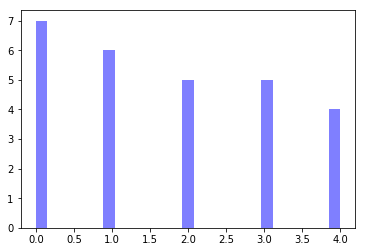

In [14]:
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import numpy as np
# пример для нулевой вакансии
num_bins = len(g11[0])
hist = np.histogram(g11[0])
plt.hist(g11[0], num_bins, facecolor='blue', alpha=0.5)
plt.show()
# слова из категории "Владение ПО" встречаются 7 раз, коммуникативные навыки: 6, личные и экономические: 5, управленческие: 4.
# вывод: скорее всего, эта вакансия больше относится к категории "Владение ПО"